In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import os

import numpy as np
import pandas as pd

from typing import List
from typing import Union
from typing import Tuple

import tslearn
from tslearn.metrics import dtw as tslearn_dtw
import pandas as pd
import hacktops
import numpy as np


/usr/users/bdmagr4/ayobi/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
SHIFT_STEP = 3
NB_SAMPLES = SHIFT_STEP * 5
WINDOW_LENGTH = 30
DILATION_RATIO = 1.5

def get_well_relevant_windows(top_index: int, df_well: pd.DataFrame, nb_samples: int=NB_SAMPLES,
                              shift: int=SHIFT_STEP, ratio: Union[None, float]=None) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """
    Given df_well : 'wellName', 'DEPTH', 'GR' and top_index the position of a top in df_well
    Returns a list of numerous windows around top_index, and their label
    Labels are either True or False
    for a given selected window it is labelled True if the distance between its center and
    the top position is less than 4

    :param top_index: int
    :param df_well: pd.DataFrame(columns=['wellName', 'DEPTH', 'GR'])
    :param nb_samples: int
    :param shift: int=SHIFT_STEP
    :param ratio: Union[None, float]=None
    :return: list
    """
    windows = []
    labels = []
    positives = 0
    negatives = 0
    for i in range(top_index - nb_samples, top_index + nb_samples, shift):
        left_limit = i - WINDOW_LENGTH
        right_limit = i + WINDOW_LENGTH
        window_data = list(map(lambda x: np.array([x]), list(df_well['GR'].values[left_limit:right_limit + 1])))
        if np.array(window_data).shape != (WINDOW_LENGTH * 2 + 1, 1):
            continue
        label = abs(df_well['DEPTH'].iloc[i] - df_well['DEPTH'].iloc[top_index]) < 4
        if ratio:
            if label:
                windows.append(np.array(window_data))
                labels.append(np.array(label))
            elif negatives / max(positives + negatives, 1) < ratio:
                pass
            else:
                windows.append(np.array(window_data))
                labels.append(np.array(label))
        else:
            windows.append(np.array(window_data))
            labels.append(np.array(label))

        if label:
            positives += 1
        else:
            negatives += 1

    return windows, labels


# TODO: check index and len depth

def generate_top_dataset(df_logs: pd.DataFrame, df_tops: pd.DataFrame,
                         top: str='CONRAD', ratio: Union[None, float]=None):
    """
    From df_logs and df_tops for each well
    return a list of relevant windows from the whole signal of the well and the labels of the windows
    a relevant window depend on the top
    for more explanation about window selection cf get_well_relevant_windows

    df_logs contains : 'wellName', 'DEPTH', 'GR'
    df_tops contains a column top

    :param df_logs: pd.DataFrame
    :param df_tops: pd.DataFrame
    :param top: str='CONRAD'
    :param ratio: Union[None, float]=None
    :return:
    """
    windows = []
    labels = []
    for well_name in df_logs['wellName'].drop_duplicates().tolist():
        df_well = df_logs[df_logs['wellName'] == well_name]
        top_position = df_tops.loc[well_name][top]
        if np.isnan(top_position):
            print("NAN FOUND")
            continue
        depth_list = list(df_well['DEPTH'].values)
        real_top_position = min(df_well['DEPTH'].values,
                                key=lambda x: abs(x - top_position))  # SOMETIMES top_position not in df_logs
        if abs(real_top_position - top_position) > 3:
            print("DATA BAD LABELLED")
            continue
        top_index = depth_list.index(real_top_position)
        windows_, labels_ = get_well_relevant_windows(top_index=top_index, df_well=df_well, shift=1, nb_samples=1 * 100,
                                                      ratio=ratio)
        windows += windows_
        labels += labels_
    return windows, labels



class TopFinder:
    """
    TopFinder: wrapper for window classifier
    
    Limitations:
    - Work on single one top and assume independence among tops
    - Find top by classifying windows extracted from well data and discard
      the correlation between windows
    - Does not utilize geographical info of wells

    Usage example:

        >>> model.fit(dataset)
        >>> model.evaluate_windows = a_func

        >>> top_finder = TopFinder(model, top_name)
        >>> top_finder.examine_dataset(df_tops)

        >>> predicted_depth = top_finder.find_top(df_well)

    """

    def __init__(self, fitted_window_classifier, top_name):
        if fitted_window_classifier.evaluate_windows is None:
            raise ValueError("fitted_window_classifier has to have function evaluate_windows")
        self.window_classifier = fitted_window_classifier
        self.work_on_top = top_name
        self.stats = {}

    def examine_dataset(self, df_tops:pd.DataFrame):
        self.stats['top_depth_max'] = df_tops[self.work_on_top].max()
        self.stats['top_depth_min'] = df_tops[self.work_on_top].min()

    def extract_window(self, df_well:pd.DataFrame, center_idx, window_length):
        left_limit = center_idx - window_length
        right_limit = center_idx + window_length
        window = df_well.loc[left_limit : right_limit, 'GR'].to_numpy()
        return window

    def get_candidate_windows(self, df_well:pd.DataFrame):
        '''
        extra prior knowledge may be used to narrow down the scope of candidates, 
        e.g. top distribution. 

        return list of windows. Each window includes the depth of its center & GR data.
        '''
        max_, min_ = self.stats['top_depth_max'], self.stats['top_depth_min']
        center_  = (max_ + min_) / 2
        depth_diff_ = max_ - min_
        dilated_max_ =  center_ + DILATION_RATIO * depth_diff_ / 2
        dilated_min_ =  center_ - DILATION_RATIO * depth_diff_ / 2

        windows = []
        for idx, row in df_well.iterrows():
            if row['DEPTH'] < dilated_max_ and row['DEPTH'] > dilated_min_:
                window_depth = row['DEPTH']
                window_data = self.extract_window(df_well, idx, WINDOW_LENGTH)
                if window_data.shape != (WINDOW_LENGTH * 2 + 1,):
                    # print(window_data.shape) 
                    # It happens when the window gets out of the scope of well depth
                    continue
                windows.append((window_depth, window_data))
        return windows

    def select_window(self, windows, scores: np.array):
        '''
        extra prior knowledge may be used here, e.g. top relationships
        '''
        index_max = np.argmax(scores, axis=0)
        return windows[index_max]

    def find_top(self, df_well):
        """
        Step:
            1. Extract all candidate windows from the well
            2. Evalute each candidate by window classifier
            3. Select the best candidate
            4. Return its associated depth
        """
        if self.window_classifier is None:
            raise Exception("window_classifier is not set")
        if df_well.shape[0] == 0:
            raise Exception("input well has no data")

        self.windows = self.get_candidate_windows(df_well)
        print(f'{len(self.windows)} candidate windows')
        windows_data = np.array([w[1] for w in self.windows])
        self.scores = self.window_classifier.evaluate_windows(windows_data)
        selected_window = self.select_window(self.windows, self.scores)
        self.top_depth = selected_window[0]

        return self.top_depth



def get_true_windows(df_logs, df_tops, top_, keep_depth = False):
    dataset = generate_top_dataset(df_logs=df_logs, df_tops=df_tops, top=top_)
    all_well_names = df_logs['wellName'].unique()
    print(f'{len(dataset[0])} windows extracted from {len(all_well_names)} wells')

    X = np.array(dataset[0]).squeeze(axis=2)
    y = np.array(dataset[1])
    
    print('X:', X.shape)
    print('y:', y.shape)

    true_idx = [idx for idx in range(len(X)) if y[idx] == True]
    print(f'{len(true_idx)} true windows left')

    return X[true_idx]

def get_true_depth(wellname, top, df_tops):
    return df_tops.loc[wellname, top]


def visual_scores(depths, scores, max_score_depth=None, true_depth=None, well_name=None):
    data = []
    data.append(go.Scatter(x=depths,y=scores))
    title = "Evaluation Score w.r.t depth"
    if well_name:
        title += f' [well: {well_name}]'
    fig = go.Figure(data=data, layout={'title':title})
    if max_score_depth:
        fig.add_vline(x=max_score_depth, line_width=2, line_color="yellow", \
            annotation_text='Predicated', annotation_position='top left')
    if true_depth:
        fig.add_vline(x=true_depth, line_width=2, line_color="green", \
            annotation_text='True', annotation_position='top right')
    return fig
def instance_norm(sample: np.array):
    s = (sample - np.min(sample)) / (np.max(sample) - np.min(sample) + 1)
    return s


In [4]:
tops = ['SYLVAIN', 'MARCEL', 'CONRAD']
top_ = 'MARCEL'
top = top_
df_logs_ = pd.read_parquet("../data/logs.parquet")
df_loc_ = pd.read_parquet("../data/loc.parquet")
df_tops_ = pd.read_parquet("../data/tops.parquet")



In [5]:

def get_well_marker(top_index: int, df_well: pd.DataFrame, window_len: int, shift: int):

    left_limit = top_index - window_len
    right_limit = top_index + window_len
    window_data = df_well['GR'].loc[left_limit:right_limit]
    window_data = np.array(window_data).reshape(-1)
    # print(top_index, df_well.shape, df_well.index[-1], len(window_data))
    return window_data

WIN_LEN = 60
SHIFT = 1

no_match_count = 0
well_marker = dict()
for well_name in df_tops_.index:
    true_depth = df_tops_.loc[well_name][top_]
    df_well = df_logs_[df_logs_['wellName'] == well_name]
    true_depth_row = df_well[df_well['DEPTH'] == true_depth]
    true_depth_idx = true_depth_row.index
    if true_depth_idx.shape[0] == 1:
        # print(well_name)
        marker = get_well_marker(true_depth_idx.values[0], df_well, WIN_LEN, SHIFT)
        well_marker[well_name] = marker
    else:
        no_match_count += 1
print(f'{no_match_count} wells don\'t match. Markers of {len(well_marker)} wells found. ') 

11 wells don't match. Markers of 589 wells found. 


In [6]:
def random_sample_n(X, k):
    samples = random.sample(X, k=k)
    return samples

def avg_window(samples: np.ndarray, normalize:bool = False):
    '''
    normalize: normalize the data or not
    '''
    if normalize:
        normalized = [instance_norm(sample) for sample in samples]
        return np.average(normalized, 0)
    else:
        return np.average(samples, 0)


Window size = 121  GR measures


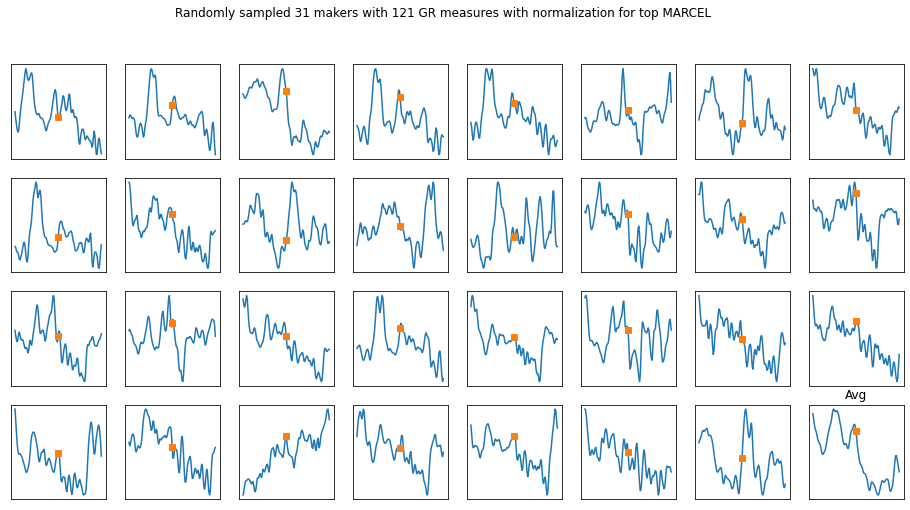

In [7]:
w, h = 4, 8
sample_num = w * h - 1
samples = random_sample_n(list(well_marker.values()), sample_num)
fig, axes = plt.subplots(w, h, figsize=(16,8))
fig.suptitle(f"Randomly sampled {sample_num} makers with {2*WIN_LEN+1} GR measures with normalization for top {top_}")
print("Window size =", 2*WIN_LEN+1, ' GR measures' )
for i, ax in enumerate(axes.flat[:-1]):
    data = samples[i]
    ax.plot(range(len(data)), data)
    ax.plot([WIN_LEN], [data[WIN_LEN]], 's')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # ax.set_title('Avg w. norm')

ax = axes.flat[-1]  
data = avg_window(samples[:-2], normalize=True)
ax.plot(range(len(data)), data)
ax.plot([WIN_LEN], [data[WIN_LEN]], 's')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Avg')

plt.show()

In [8]:
from dtaidistance import dtw
from scipy.spatial.distance import pdist

In [9]:
well_names = list(well_marker.keys())
dist_m_wo_norm = dtw.distance_matrix_fast(list(well_marker.values()))
dist_m_w_norm = dtw.distance_matrix_fast([instance_norm(marker) for marker in list(well_marker.values())])

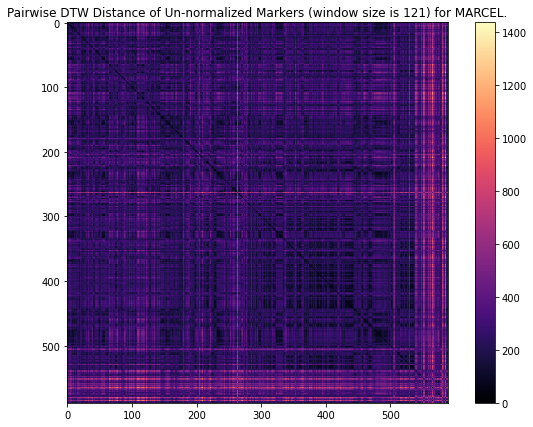

In [10]:
# Heat map
plt.figure(figsize = (10,7))
plt.imshow(dist_m_wo_norm , cmap = 'magma')

plt.title( f"Pairwise DTW Distance of Un-normalized Markers (window size is {2*WIN_LEN+1}) for {top_}." )
plt.colorbar()
plt.savefig(fname='dtw_distance_matrix/' + f'{top_}-{WIN_LEN}-{df_tops_.shape[0]}-unnormalized.png')
plt.show()

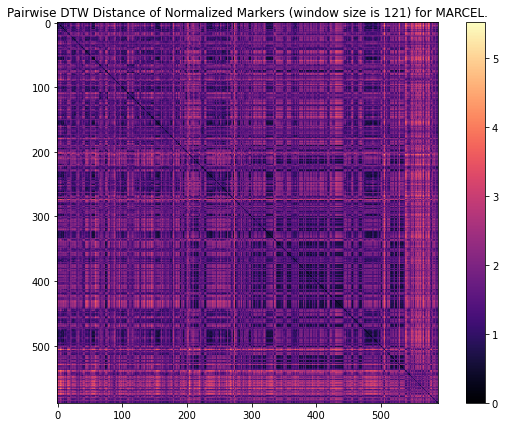

In [11]:
# Heat map
plt.figure(figsize = (10,7))
plt.imshow(dist_m_w_norm , cmap = 'magma')

# plt.title( f"Pairwise DTW Distance of Normalized Markers for {top_}" )
plt.title( f"Pairwise DTW Distance of Normalized Markers (window size is {2*WIN_LEN+1}) for {top_}." )
plt.colorbar()
plt.savefig(fname='dtw_distance_matrix/' + f'{top_}-{WIN_LEN}-{df_tops_.shape[0]}-normalized.png')
plt.show()
# plt.savefig(fname = f'dtw_distance_matrix/{top_}-{df_tops_.shape[0]}-normalized.png')

In [12]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(metric='precomputed', min_samples=10, eps=0.5, algorithm="brute")
clustering.fit(dist_m_w_norm)


DBSCAN(algorithm='brute', metric='precomputed', min_samples=10)

In [13]:
len(clustering.labels_), set(clustering.labels_)

(589, {-1, 0, 1, 2, 3})

In [14]:
labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d from %d data points" % (n_noise_, len(labels)))

# label_id -> [wellnames]
clustered_well_names = {label : [well_names[i] for i, l in enumerate(labels) if l == label] for label in set(labels)}
for label, wns in clustered_well_names.items():
    print(f"label {label}: {len(wns)} wells")

Estimated number of clusters: 4
Estimated number of noise points: 193 from 589 data points
label 0: 200 wells
label 1: 19 wells
label 2: 155 wells
label 3: 22 wells
label -1: 193 wells


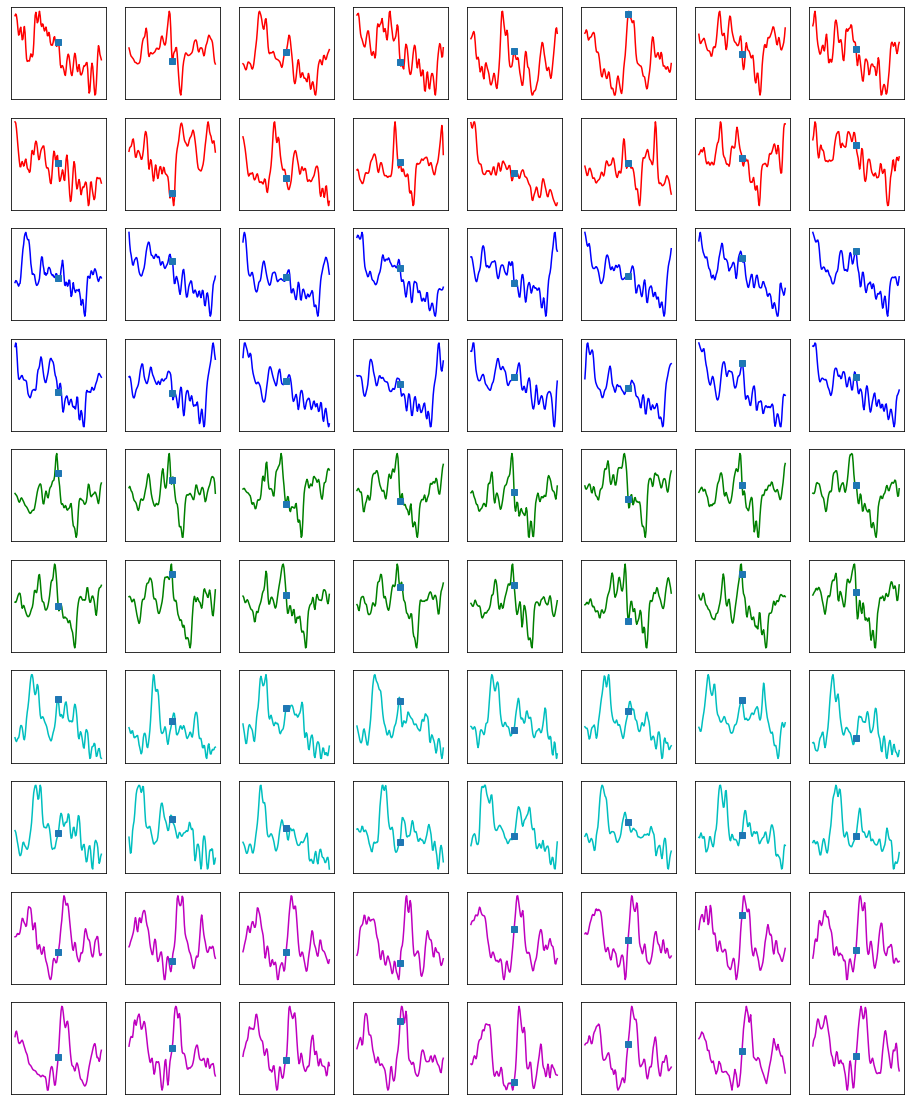

In [15]:
w, h = 2 * n_clusters_ + 2 , 8
sample_num = 16
samples = {label: [well_marker[wn] for wn in random_sample_n(wns, min(sample_num, len(wns)))] for label, wns in clustered_well_names.items()}

fig, axes = plt.subplots(w, h, figsize=(16, 4+4*n_clusters_))
# fig.suptitle(f"Randomly sampled clustered/noise makers with {2*WIN_LEN+1} GR measures with normalization for top {top_}")
# print("Window size =", 2*WIN_LEN+1, ' GR measures' )

for i, ax in enumerate(axes.flat[:min(sample_num, len(clustered_well_names[-1]))]):
    data = samples[-1][i]
    ax.plot(range(len(data)), data, color='r')
    ax.plot([WIN_LEN], [data[WIN_LEN]], 's')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

colors = ['b', 'g', 'c', 'm', 'y', 'k', 'b', 'g']
for k in range(n_clusters_):
    label = [l for l in list(samples.keys()) if l != -1][k]
    wn_nums = len(clustered_well_names[label])
    for i, ax in enumerate(axes.flat[sample_num*(k+1) : sample_num*(k+1) + min(sample_num, wn_nums) ]):
        data = samples[k][i]
        ax.plot(range(len(data)), data, color=colors[k])
        ax.plot([WIN_LEN], [data[WIN_LEN]], 's')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # ax.set_title('Avg w. norm')


plt.show()

In [16]:
df = pd.DataFrame({'wellName': well_names , 'cluster': labels})

Uploading The datasets

In [17]:

#uncomment the top to work with one top at a time

#top = 'CONRAD' 
#top = 'SYLVAIN'
#top = 'MARCEL'
df_logs = pd.read_parquet("../data/logs.parquet")
df_loc = pd.read_parquet("../data/loc.parquet")
df_tops = pd.read_parquet("../data/tops.parquet")

df_logs_test = pd.read_parquet("../testdata/logs_50.parquet")
df_loc_test = pd.read_parquet("../testdata/loc_50.parquet")
df_tops_test = pd.read_csv("../testdata/tops_50.csv", index_col=0)

In [18]:
merged_df = pd.merge(df_tops_, df, left_on='wellName', right_on='wellName', how='right')

In [19]:
df_tops_ = filtered_df = merged_df[(merged_df['cluster'] == 0)].drop('cluster', axis=1).set_index('wellName')


In [20]:
valid_wells = df_tops_.index.values.tolist()


In [21]:
df_logs_ =  df_logs_[df_logs_['wellName'].isin(valid_wells)]

In [22]:
df_logs_

,wellName,DEPTH,GR
1,512320698.0,421.0,96.9752
2,512320698.0,421.5,102.3324
3,512320698.0,422.0,104.6432
4,512320698.0,422.5,99.2187
5,512320698.0,423.0,92.0200
...,...,...,...
9637822,512335370.0,8938.5,139.3476
9637823,512335370.0,8939.0,139.3476
9637824,512335370.0,8939.5,139.3476
9637825,512335370.0,8940.0,139.3476


In [23]:
train_dataset = generate_top_dataset(df_logs= df_logs, df_tops=df_tops, top=top)
test_dataset = generate_top_dataset(df_logs=df_logs_test, df_tops=df_tops_test, top=top)

NAN FOUND


Data Pipeline

In [24]:
X = np.array(train_dataset[0]).squeeze(axis=2)
y = np.array(train_dataset[1])

X_test= np.array(test_dataset[0]).squeeze(axis=2)
y_test = np.array(test_dataset[1])

In [25]:
print("Training set: ", X.shape,y.shape)
print("Testing set: ", X_test.shape,y_test.shape)

Training set:  (119800, 61) (119800,)
Testing set:  (10000, 61) (10000,)


Time series to Image Transformation

To work with CNN the time series need to be changed data grid-like format, therefore the data will be changed to image format of GASF,GADF and MTF

In [26]:
# a method to change timeseries to either Gramian Angular Summation Field (gasf) or Gramian Angular Difference Field (gadf)

def gaf(X,method):
    from pyts.image import GramianAngularField
    transformer = GramianAngularField(method=method)
    X_new = transformer.transform(X)
    X_new = np.expand_dims(X_new,axis=3)
    return X_new

In [27]:
# a method to change timeseries to Markov Transition Field (MTF)

def mtf(X):
    from pyts.image import MarkovTransitionField
    transformer = MarkovTransitionField()
    X_new = transformer.transform(X)
    X_new = np.expand_dims(X_new,axis=3)
    return X_new

In [28]:
# a method to change timeseries to the combined format of gasf,gadf and mtf

def combined(X):
    X_gasf=gaf(X,method='summation')
    X_gadf=gaf(X,method='difference')
    X_mtf= mtf(X)
    X_new=np.concatenate((X_gasf,X_gadf,X_mtf),axis=3)
    return X_new

Caling function for changing the time series to image
Make sure to choose one image format for both training and testing dataset

In [29]:
#call one funcion at a time
#X_new= mtf(X)
X_new= gaf(X,method='summation') #for gasf
#X_new= gaf(X,method='difference') #for gadf
#X_new= combined(X)
X_new.shape

(119800, 61, 61, 1)

In [30]:
#X_test= mtf(X_test)
X_test= gaf(X_test,method='summation') #for gasf
#X_test= gaf(X_test,method='difference') #for gadf
#X_test= combined(X_test)
X_test.shape

(10000, 61, 61, 1)

Visualization

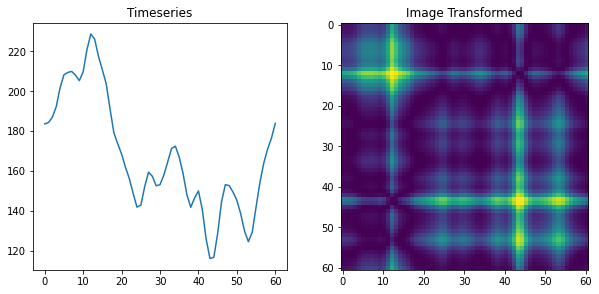

In [31]:
#visualize the tranformed timeseries of the first well in a dataset
f, axs = plt.subplots(1,2,figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Timeseries')
plt.plot(X[0])
plt.subplot(2,2,2)
plt.title('Image Transformed')
plt.imshow(X_new[0])

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_new, y, test_size=0.33, random_state = 0)

In [33]:
print('Training Sets',X_train.shape, y_train.shape)
print('Validation Sets',X_val.shape, y_val.shape)

Training Sets (80266, 61, 61, 1) (80266,)
Validation Sets (39534, 61, 61, 1) (39534,)


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [36]:

#Model training 
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='sigmoid', input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size=3, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = EarlyStopping(monitor='val_loss',patience=3, restore_best_weights=True)
print(model.summary())



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 59, 59, 64)        640       
_________________________________________________________________
dropout_2 (Dropout)          (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 57, 57, 32)        18464     
_________________________________________________________________
dropout_3 (Dropout)          (None, 57, 57, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

In [37]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=callback)

#load mtf for conrad
#model= load_model('model/conrad/mtf/model.h5')

#model.save_weights('model/conrad/mtf/weights.h5')

Epoch 1/10
2509/2509 [==============================] - 246s 98ms/step - loss: 0.2747 - accuracy: 0.9234 - val_loss: 0.2412 - val_accuracy: 0.9268
Epoch 2/10
2509/2509 [==============================] - 241s 96ms/step - loss: 0.2466 - accuracy: 0.9237 - val_loss: 0.2394 - val_accuracy: 0.9273
Epoch 3/10
2509/2509 [==============================] - 240s 96ms/step - loss: 0.2430 - accuracy: 0.9239 - val_loss: 0.2389 - val_accuracy: 0.9261
Epoch 4/10
2509/2509 [==============================] - 243s 97ms/step - loss: 0.2402 - accuracy: 0.9237 - val_loss: 0.2299 - val_accuracy: 0.9267
Epoch 5/10
2509/2509 [==============================] - 244s 97ms/step - loss: 0.2388 - accuracy: 0.9239 - val_loss: 0.2344 - val_accuracy: 0.9269
Epoch 6/10
2509/2509 [==============================] - 241s 96ms/step - loss: 0.2361 - accuracy: 0.9238 - val_loss: 0.2275 - val_accuracy: 0.9263
Epoch 7/10
2509/2509 [==============================] - 249s 99ms/step - loss: 0.2332 - accuracy: 0.9234 - val_loss: 0

Save the model for future use!
Each model is for a specific top and a specific image format, therefore it will be 3X4=12 saved models, meaning 3 tops and 4 images format

In [ ]:
#Uncomment one of the below lines of code to save the model based on the choosen image format

#FOR CONRAD
#model.save('model/conrad/mtf/model.h5')
#model.save('model/conrad/gasf/model.h5')
#model.save('model/conrad/gadf/model.h5')
#model.save('model/conrad/combined/model.h5')

#FOR MARCEL
#model.save('model/marcel/mtf/model.h5')
#model.save('model/marcel/gasf/model.h5')
#model.save('model/marcel/gadf/model.h5')
#model.save('model/marcel/combined/model.h5')

#FOR SYLVAIN
#model.save('model/sylvain/mtf/model.h5')
#model.save('model/sylvain/gasf/model.h5')
#model.save('model/sylvain/gadf/model.h5')
#model.save('model/sylvain/combined/model.h5')


Prediction Results Summmary

In [40]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,cohen_kappa_score, roc_auc_score

In [41]:
y_pred = np.argmax(model.predict(X_test), axis=-1)


In [42]:

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

Accuracy: 0.925400
Precision: 1.000000
Recall: 0.005333
F1 score: 0.010610


Classification Report

In [43]:

print('Prediction Accuracy Score {:.2f}.'.format(accuracy_score(y_test,y_pred)))
clax_report = classification_report(y_test,y_pred,output_dict=True)
report_df = pd.DataFrame(clax_report).transpose()
report_df

print('Training Process Completed')

Prediction Accuracy Score 0.93.
Training Process Completed


TESTING START HERE!
In the below code of lines is for testing the how to extract a specific depth where the top is found!

In [44]:

from plotly.offline import iplot
from tqdm import tqdm


In [48]:
def evaluate_windows(self, candidate_windows):
    #well= mtf(candidate_windows)
    well= gaf(candidate_windows,method='summation')
    #well= gaf(candidate_windows,method='difference')
    #well= combined(candidate_windows)
    return self.predict(well)[:,1]
import types
model.evaluate_windows = types.MethodType(evaluate_windows, model)

In [49]:
top_finder = TopFinder(model, top)
top_finder.examine_dataset(df_tops) #what is this top

In [50]:
test_well_names = df_logs_test['wellName'].unique()
print(len(test_well_names))

50


In [51]:
result = []
for test_well_name in tqdm(test_well_names):
    # print(f'well: {test_well_name}')
    df_test_well = df_logs_test[df_logs_test['wellName'] == test_well_name]
    predicted_depth = top_finder.find_top(df_test_well)
    true_depth = get_true_depth(test_well_name, top, df_tops_test)
    result.append([test_well_name, predicted_depth, true_depth])


  0%|          | 0/50 [00:00<?, ?it/s]

2668 candidate windows


  2%|▏         | 1/50 [00:01<01:20,  1.64s/it]

2674 candidate windows


  4%|▍         | 2/50 [00:03<01:18,  1.64s/it]

2528 candidate windows


  6%|▌         | 3/50 [00:04<01:16,  1.64s/it]

2256 candidate windows


  8%|▊         | 4/50 [00:06<01:12,  1.58s/it]

2813 candidate windows


 10%|█         | 5/50 [00:08<01:13,  1.64s/it]

2774 candidate windows


 12%|█▏        | 6/50 [00:09<01:12,  1.66s/it]

2508 candidate windows


 14%|█▍        | 7/50 [00:11<01:10,  1.63s/it]

2270 candidate windows


 16%|█▌        | 8/50 [00:12<01:06,  1.58s/it]

2524 candidate windows


 18%|█▊        | 9/50 [00:14<01:04,  1.58s/it]

2654 candidate windows


 20%|██        | 10/50 [00:16<01:03,  1.60s/it]

2510 candidate windows


 22%|██▏       | 11/50 [00:17<01:02,  1.61s/it]

2336 candidate windows


 24%|██▍       | 12/50 [00:19<01:00,  1.59s/it]

2246 candidate windows


 26%|██▌       | 13/50 [00:20<00:57,  1.56s/it]

2176 candidate windows


 28%|██▊       | 14/50 [00:22<00:54,  1.53s/it]

2240 candidate windows


 30%|███       | 15/50 [00:23<00:53,  1.52s/it]

2813 candidate windows


 32%|███▏      | 16/50 [00:25<00:53,  1.56s/it]

2813 candidate windows


 34%|███▍      | 17/50 [00:27<00:52,  1.60s/it]

2813 candidate windows


 36%|███▌      | 18/50 [00:28<00:51,  1.61s/it]

2550 candidate windows


 38%|███▊      | 19/50 [00:30<00:49,  1.61s/it]

2614 candidate windows


 40%|████      | 20/50 [00:31<00:48,  1.61s/it]

2668 candidate windows


 42%|████▏     | 21/50 [00:33<00:46,  1.62s/it]

2636 candidate windows


 44%|████▍     | 22/50 [00:35<00:45,  1.62s/it]

2612 candidate windows


 46%|████▌     | 23/50 [00:36<00:44,  1.63s/it]

2454 candidate windows


 48%|████▊     | 24/50 [00:38<00:41,  1.60s/it]

2140 candidate windows


 50%|█████     | 25/50 [00:39<00:38,  1.54s/it]

2396 candidate windows


 52%|█████▏    | 26/50 [00:41<00:36,  1.53s/it]

2580 candidate windows


 54%|█████▍    | 27/50 [00:42<00:35,  1.56s/it]

2596 candidate windows


 56%|█████▌    | 28/50 [00:44<00:34,  1.56s/it]

2562 candidate windows


 58%|█████▊    | 29/50 [00:46<00:33,  1.58s/it]

2632 candidate windows


 60%|██████    | 30/50 [00:47<00:31,  1.60s/it]

2564 candidate windows


 62%|██████▏   | 31/50 [00:49<00:30,  1.59s/it]

2498 candidate windows


 64%|██████▍   | 32/50 [00:50<00:28,  1.57s/it]

2066 candidate windows


 66%|██████▌   | 33/50 [00:52<00:25,  1.52s/it]

2066 candidate windows


 68%|██████▊   | 34/50 [00:53<00:23,  1.47s/it]

2664 candidate windows


 70%|███████   | 35/50 [00:55<00:22,  1.51s/it]

2604 candidate windows


 72%|███████▏  | 36/50 [00:56<00:21,  1.54s/it]

2452 candidate windows


 74%|███████▍  | 37/50 [00:58<00:20,  1.54s/it]

2572 candidate windows


 76%|███████▌  | 38/50 [00:59<00:18,  1.54s/it]

2572 candidate windows


 78%|███████▊  | 39/50 [01:01<00:17,  1.58s/it]

2592 candidate windows


 80%|████████  | 40/50 [01:03<00:16,  1.60s/it]

2366 candidate windows


 82%|████████▏ | 41/50 [01:04<00:14,  1.58s/it]

2168 candidate windows


 84%|████████▍ | 42/50 [01:06<00:12,  1.55s/it]

2414 candidate windows


 86%|████████▌ | 43/50 [01:07<00:10,  1.53s/it]

2468 candidate windows


 88%|████████▊ | 44/50 [01:09<00:09,  1.55s/it]

2552 candidate windows


 90%|█████████ | 45/50 [01:10<00:07,  1.55s/it]

2178 candidate windows


 92%|█████████▏| 46/50 [01:12<00:06,  1.50s/it]

2016 candidate windows


 94%|█████████▍| 47/50 [01:13<00:04,  1.46s/it]

2088 candidate windows


 96%|█████████▌| 48/50 [01:15<00:02,  1.46s/it]

2140 candidate windows


 98%|█████████▊| 49/50 [01:16<00:01,  1.45s/it]

1958 candidate windows


100%|██████████| 50/50 [01:17<00:00,  1.56s/it]


In [52]:
df_result = pd.DataFrame(result, columns=['wellName', 'predicated_depth', 'true_depth']).set_index('wellName')
df_tops_pred = df_result[['predicated_depth']].rename(columns={'predicated_depth': top})
df_tops_true = df_result[['true_depth']].rename(columns={'true_depth': top})

In [53]:
from hacktops.evaluate import recall_tops

recall, mae, df_res = recall_tops(df_tops_true, df_tops_pred, tolerance = 4)
print("recall {0}, mae {1}".format(recall,mae))
df_res.head(50)

recall 0.18, mae 230.7


,MARCEL,MARCEL_pred,MARCEL_ae,MARCEL_tp
wellName,,,,
512320936.0,6514.0,5999.5,514.5,False
512320968.0,6539.0,5729.5,809.5,False
512320984.0,6471.0,6474.0,3.0,True
512322242.0,6370.0,6368.0,2.0,True
512322535.0,6460.0,5864.5,595.5,False
512322732.0,6567.5,6630.5,63.0,False
512322775.0,6460.0,6096.0,364.0,False
512322788.0,6371.0,6370.0,1.0,True
512322802.0,6560.0,6566.0,6.0,False


In [ ]:
len(df_res)

Visualizing a well

In [ ]:
depth = [w[0] for w in top_finder.windows]
fig = visual_scores(depth, top_finder.scores, top_finder.top_depth, true_depth, test_well_name)
iplot(fig)